## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Camera calibration

In [2]:
import numpy as np
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def calibrate():
    """
    Calibrate camera using a set of chessboard images
    """
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    for fname in glob.glob('camera_cal/calibration*.jpg'):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # print('{}: {}'.format(fname, gray.shape))
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print('Failed to detect corners for {}'.format(fname))

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280, 720), None, None)
    assert(ret)
    return mtx, dist

def undistort(img, mtx, dist):
    """
    Undistort the input image, using the given mtx and dist matrices
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

In [4]:
mtx, dist = calibrate()

Failed to detect corners for camera_cal/calibration1.jpg
Failed to detect corners for camera_cal/calibration4.jpg
Failed to detect corners for camera_cal/calibration5.jpg


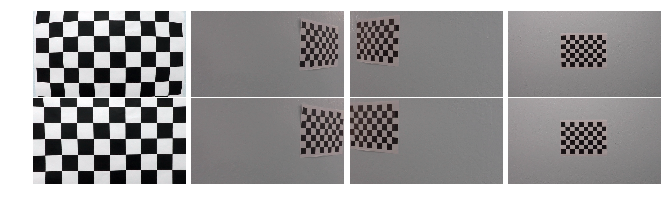

In [5]:
def test_calibrate():
    files = ['calibration1.jpg', 'calibration14.jpg', 'calibration19.jpg', 'calibration6.jpg']
    gs = mpl.gridspec.GridSpec(2, len(files))
    gs.update(wspace=0.00001, hspace=0.01, left=0.1, right=0.9, bottom=0.1, top=0.9)
    plt.figure(figsize=(11, 3))
    for idx, fname in enumerate(files):
        test_img = cv2.imread('camera_cal/{}'.format(fname))
        test_img_undistort = undistort(test_img, mtx, dist)
        plt.subplot(gs[idx])
        plt.imshow(test_img)
        plt.axis('off')
        plt.subplot(gs[len(files) + idx])
        plt.imshow(test_img_undistort)
        plt.axis('off')
    plt.show()
    
test_calibrate()

## 2. Thresholding

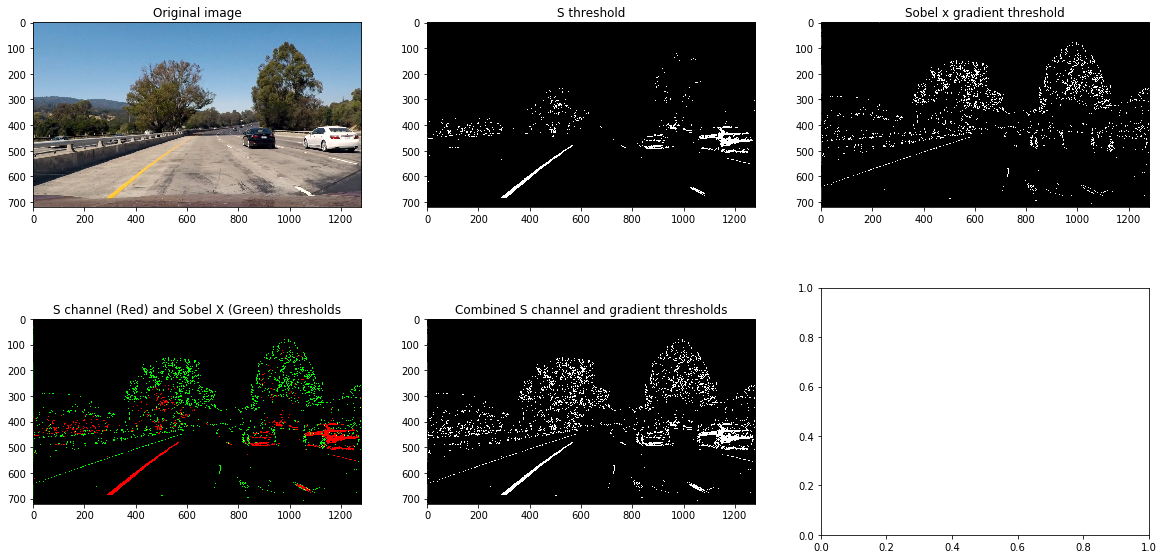

In [6]:
def binarize(img, display=False, s_thres=(170, 255), sobel_thres=(30, 80)):
    """
    Input image should be in BGR
    """
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:, :, 2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thres[0]) & (s_channel <= s_thres[1])] = 1
    
    # Sobel x
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = hls[:, :, 1]
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sobel_thres[0]) & (scaled_sobel <= sobel_thres[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    if display:
        f, axs = plt.subplots(2, 3, figsize=(20, 10))
        axs[0][0].set_title('Original image')
        axs[0][0].imshow(img[:,:,::-1])

        axs[0][1].set_title('S threshold')
        axs[0][1].imshow(s_binary, cmap='gray')

        axs[0][2].set_title('Sobel x gradient threshold')
        axs[0][2].imshow(sxbinary, cmap='gray')

        axs[1][0].set_title('S channel (Red) and Sobel X (Green) thresholds')
        axs[1][0].imshow(np.dstack((255 * s_binary, 255 * sxbinary, np.zeros_like(sxbinary))))

        axs[1][1].set_title('Combined S channel and gradient thresholds')
        axs[1][1].imshow(combined_binary, cmap='gray')
        
    return combined_binary

binary_img = binarize(cv2.imread('test_images/test1.jpg'), True)
plt.show()

## 3. Perspective transform

In [7]:
def get_transform():
    src = np.float32([
        [595, 450], 
        [685, 450],
        [1040, 674],
        [269, 674]])
    dst = np.float32([
        [200, 10], 
        [1000, 10],
        [1000, 700],
        [200, 700]])
    return cv2.getPerspectiveTransform(src, dst)
    
def warp(M, img):
    # keep same size as input image
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)

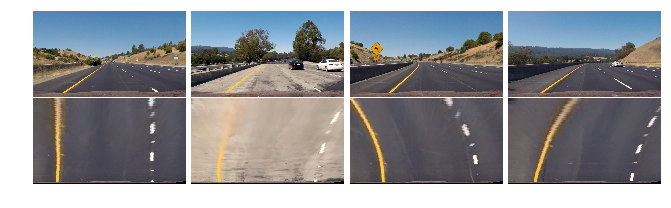

In [8]:
def test_warp():
    files = ['test_images/straight_lines1.jpg', 'test_images/test1.jpg', 
             'test_images/test2.jpg', 'test_images/test3.jpg']
    gs = mpl.gridspec.GridSpec(2, len(files))
    gs.update(wspace=0.00001, hspace=0.01, left=0.1, right=0.9, bottom=0.1, top=0.9)
    plt.figure(figsize=(11, 3))
    transform_matrix = get_transform()
    for idx, fname in enumerate(files):
        test_img = cv2.imread(fname)
        test_img_warp = warp(transform_matrix, test_img)
        plt.subplot(gs[idx])
        plt.imshow(test_img[:, :, ::-1])
        plt.axis('off')
        plt.subplot(gs[len(files) + idx])
        plt.imshow(test_img_warp[:, :, ::-1])
        plt.axis('off')
    plt.show()

test_warp()

## 4. Detect lane lines

In [9]:
def detect_lanes(binary_warped):
    """
    binary_warped is a binary image
    """
    histogram = np.sum(binary_warped[(binary_warped.shape[0] // 2):, :], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9

    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Visualize
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, out_img

In [10]:
def infer_lanes(binary_warped, left_fit, right_fit):
    """
    :param binary_warped: binary image
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Visualize
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return left_fitx, right_fitx, result

## 5. Pipeline on test images

In [11]:
mtx, dist = calibrate()
transform_matrix = get_transform()

Failed to detect corners for camera_cal/calibration1.jpg
Failed to detect corners for camera_cal/calibration4.jpg
Failed to detect corners for camera_cal/calibration5.jpg


In [12]:
def preprocess(img):
    """
    img should be a BGR image
    Returns the binary warped image
    """
    undistorted = undistort(img, mtx, dist)
    warped = warp(transform_matrix, undistorted)
    binary_img = binarize(warped, s_thres=(170, 255), sobel_thres=(15, 255))
    return binary_img

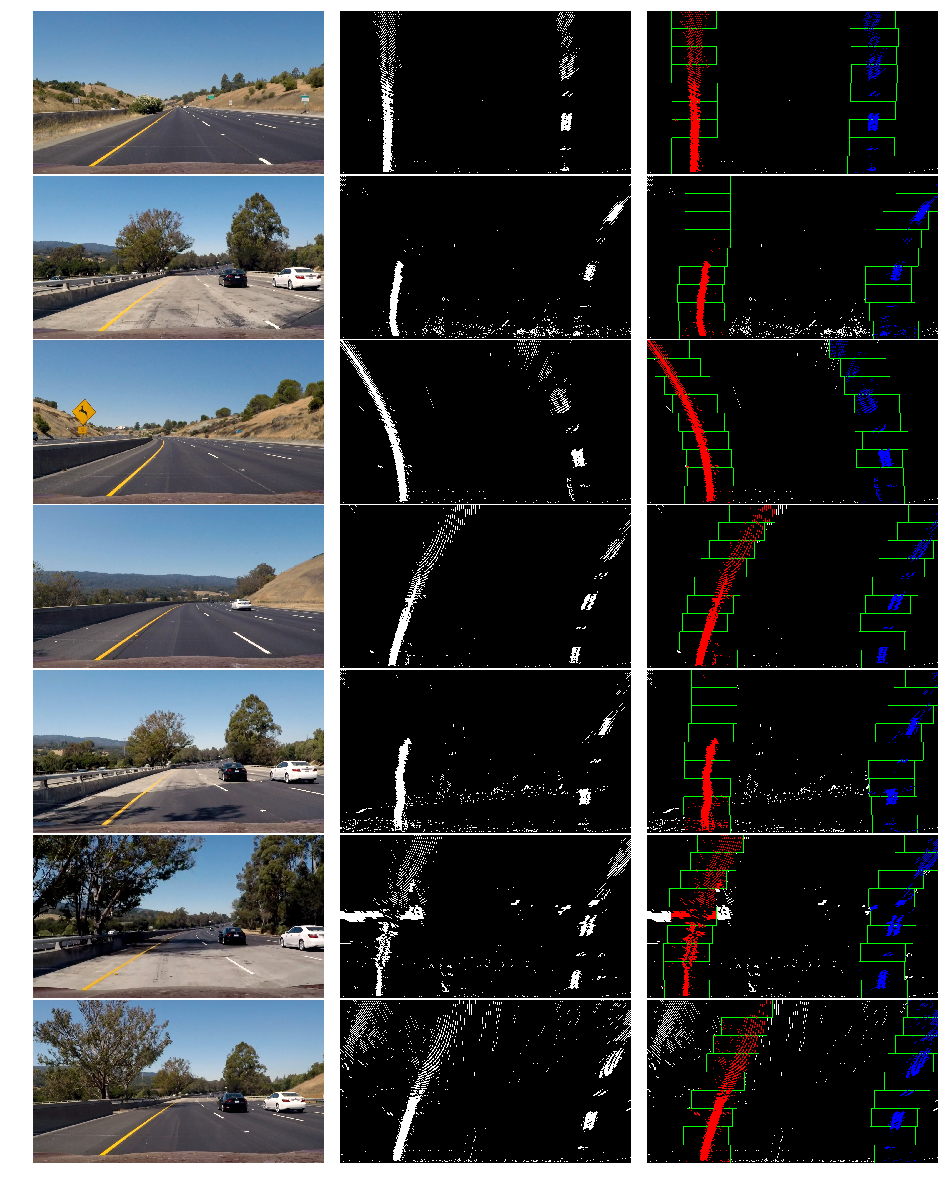

In [13]:
def test_preprocess():
    files = ['test_images/straight_lines1.jpg', 
             'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg',
             'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']
    
    gs = mpl.gridspec.GridSpec(len(files), 3)
    gs.update(wspace=0.00001, hspace=0.01, left=0.1, right=0.9, bottom=0.1, top=0.9)
    plt.figure(figsize=(16, 20))
    for idx, fname in enumerate(files):
        test_img = cv2.imread(fname)
        test_img_warp = preprocess(test_img)
        
        left_fit, right_fit, lanes_img = detect_lanes(test_img_warp)
        
        plt.subplot(gs[3 * idx])
        plt.imshow(test_img[:, :, ::-1])
        plt.axis('off')
        
        plt.subplot(gs[3 * idx + 1])
        plt.imshow(test_img_warp, cmap='gray')
        plt.axis('off')
        
        plt.subplot(gs[3 * idx + 2])
        plt.imshow(lanes_img)
        plt.axis('off')
        
    plt.show()

test_preprocess()

## 6. Pipeline on video

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
left_fit = None
right_fit = None

def process_image(image):
    global left_fit
    global right_fit
    test_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    test_img_warp = preprocess(test_img)

    if left_fit is None or right_fit is None:
        left_fit, right_fit, lanes_img = detect_lanes(test_img_warp)
    else:
        left_fit, right_fit, lanes_img = infer_lanes(test_img_warp, left_fit, right_fit)
    return lanes_img

def detect_video(inp_file, out_file):
    out_clip = VideoFileClip(inp_file).fl_image(process_image)
    %time out_clip.write_videofile(out_file, audio=False)

In [21]:
detect_video('project_video.mp4', 'project_video_detected.mp4')

[MoviePy] >>>> Building video project_video_detected.mp4
[MoviePy] Writing video project_video_detected.mp4


  0%|          | 1/1261 [00:00<02:08,  9.80it/s]

LinAlgError: SVD did not converge in Linear Least Squares